In [33]:
import os
import re
import pandas as pd

# 1) Helper function to process one file:
def load_and_label(filepath: str) -> pd.DataFrame:
    """
    Reads a single Excel file, extracts header rows (13 & 17), reads data from row 19 onward,
    builds column names, and appends a 'year' column based on the filename.
    """
    # --- Read header rows (rows 1–17) to grab labels ---
    headers_df = pd.read_excel(
        filepath,
        header=None,
        nrows=17
    )
    row13_labels = headers_df.iloc[12]   # Excel row 13
    row17_labels = headers_df.iloc[16]   # Excel row 17

    # --- Read the actual data from row 19 onward ---
    data_df = pd.read_excel(
        filepath,
        header=None,
        skiprows=18   # skip rows 1–18 so DataFrame row 0 == Excel row 19
    )

    # --- Build column names using the two header rows ---
    n_cols = data_df.shape[1]
    column_names = []
    for idx in range(n_cols):
        if idx < 9:
            # Columns A–I use labels from row 17
            column_names.append(row17_labels[idx])
        else:
            # Columns J onward use labels from row 13
            column_names.append(row13_labels[idx])
    data_df.columns = column_names

    # --- Extract the year from the filename using regex ---
    fname = os.path.basename(filepath)
    m = re.search(r'despesas-pagas-liquidas-(\d{4})\.xls[x]?$', fname, re.IGNORECASE)
    year = m.group(1) if m else None
    data_df['year'] = year  # append 'year' column

    return data_df

# 2) Directory and filename pattern setup
folder_path = './input_datasets/financial'  # update to your folder path
pattern = re.compile(r'despesas-pagas-liquidas-\d{4}\.xls[x]?$', re.IGNORECASE)

# 3) Loop over files, process matches, and collect DataFrames
all_dfs = []
for filename in os.listdir(folder_path):
    if pattern.match(filename):
        full_path = os.path.join(folder_path, filename)
        df = load_and_label(full_path)
        all_dfs.append(df)

# 4) Concatenate all into one DataFrame, resetting the index
combined_df = pd.concat(all_dfs, ignore_index=True)

# 5) Drop any columns whose name is NaN (missing header label)
combined_df = combined_df.loc[:, combined_df.columns.notna()]

despesas_df = combined_df

# ------------------------------------------------------------
# 6) Normalize specific column names:
#    - 'Designação'       → 'autarquia'
#    - 'Data Actualização' → 'date'
#    - 'NIF'               → 'nif'
# ------------------------------------------------------------
rename_map = {
    'Designação': 'autarquia',
    'Data Atualização': 'date',
    'NIF': 'nif'
}
despesas_df.rename(columns=rename_map, inplace=True)

# ------------------------------------------------------------
# 7) Remove any leading apostrophe from **all** column names
#    .lstrip("'") drops leading ' characters, if present
# ------------------------------------------------------------
despesas_df.columns = [
    col.lstrip("'") if isinstance(col, str) else col
    for col in despesas_df.columns
]

# ------------------------------------------------------------
# 8) Drop the "Tipo Economica" column if it exists
# ------------------------------------------------------------
if 'Tipo Economica' in despesas_df.columns:
    despesas_df.drop(columns=['Tipo Economica'], inplace=True)
else:
    print("Warning: 'Tipo Economica' column not found in despesas_df")

# ------------------------------------------------------------
# Drop any “note” rows where:
#  - the first column has a non-null value
#  - all columns _except_ the first column and 'year' are null/empty
# ------------------------------------------------------------
first_col = despesas_df.columns[0]  # name of the first column

# Build the list of columns to check for emptiness (exclude first_col and 'year')
cols_to_check = [c for c in despesas_df.columns if c not in {first_col, 'year'}]

# Create a boolean mask: True for rows where first_col has data AND all cols_to_check are NaN
mask = (
    despesas_df[first_col].notna()
    & despesas_df[cols_to_check].isna().all(axis=1)
)

# Drop those rows
despesas_df = despesas_df.loc[~mask].copy()


# ------------------------------------------------------------
# 9) Specify the output folder and filename
# ------------------------------------------------------------
output_folder = './datasets/financial'
output_filename = 'despesas_combinadas.xlsx'
output_path = os.path.join(output_folder, output_filename)

# 10) Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# 11) Write the DataFrame to Excel
despesas_df.to_excel(
    output_path,
    index=False,
    engine='openpyxl'
)

print(f"Exported despesas_df to Excel at: {output_path}")


Exported despesas_df to Excel at: ./datasets/financial/despesas_combinadas.xlsx


In [34]:
# ------------------------------------------------------------
# Define the list of columns you want in your summary DataFrame
# ------------------------------------------------------------
desired_columns = [
    'year',               
    'autarquia',          
    '0100000000',          # despesas_com_pessoal
    '0200000000',          # aquisicao_bens_servicos
    '0300000000',          # juros_outros_encargos
    '0400000000',          # transferencias_correntes
    '0500000000',          # subsidios
    '0600000000',          # outras_despesas_correntes
    '0700000000',          # aquisicoes_bens_capital
    '0800000000',          # transferencias_capital
    '0900000000',          # activos_financeiros
    '1000000000',          # passivos_financeiros  
    '1100000000'           # outras_despesas_capital
]   

# ------------------------------------------------------------
# Optionally check for any columns in desired_columns that aren’t in despesas_df
# ------------------------------------------------------------
missing = [col for col in desired_columns if col not in despesas_df.columns]
if missing:
    print(f"Warning: these columns were not found and will be skipped: {missing}")

# ------------------------------------------------------------
# Build the summary DataFrame by selecting only the intersection
# of desired_columns and the actual columns present
# ------------------------------------------------------------
available = [col for col in desired_columns if col in despesas_df.columns]
despesas_resume_df = despesas_df[available].copy()

# ------------------------------------------------------------
# After creating despesas_resume_df with your desired numeric columns...
# ------------------------------------------------------------

# 1) Identify which columns are numeric expense categories
numeric_cols = [
    col for col in despesas_resume_df.columns
    if col not in ('year', 'autarquia')
]

# 2) Compute a row‑wise total of all those expense columns
#    This gives the denominator for percentage calculations
despesas_resume_df['total_expenses'] = despesas_resume_df[numeric_cols].sum(axis=1)

# 3) For each numeric column, calculate its percentage of the total
for col in numeric_cols:
    # New column name ends with '_percent'
    pct_col = f"{col}_percent"
    # Value ÷ row total × 100
    despesas_resume_df[pct_col] = (
        despesas_resume_df[col] 
        / despesas_resume_df['total_expenses'] 
        * 100
    )

# 4) (Optional) If you don’t need the intermediate total column, drop it:
# despesas_resume_df.drop(columns=['total_expenses'], inplace=True)
# ------------------------------------------------------------
# Rename the numeric code columns (and their '_percent' siblings)
# ------------------------------------------------------------
# 1) Define a mapping from the old codes to descriptive names
code_rename_map = {
    '0100000000': 'despesas_com_pessoal',
    '0200000000': 'aquisicao_bens_servicos',
    '0300000000': 'juros_outros_encargos',
    '0400000000': 'transferencias_correntes',
    '0500000000': 'subsidios',
    '0600000000': 'outras_despesas_correntes',
    '0700000000': 'aquisicoes_bens_capital',
    '0800000000': 'transferencias_capital',
    '0900000000': 'activos_financeiros',
    '1000000000': 'passivos_financeiros',
    '1100000000': 'outras_despesas_capital'
}

# 2) Also rename the corresponding percentage columns
percent_rename_map = {
    f"{code}_percent": f"{name}_percent"
    for code, name in code_rename_map.items()
}

# 3) Combine both maps
rename_map = {**code_rename_map, **percent_rename_map}

# 4) Apply the renaming to your summary DataFrame
despesas_resume_df.rename(columns=rename_map, inplace=True)

# 5) (Optional) Verify the result
print(despesas_resume_df.columns.tolist())


# 5) Sanity-check
print(despesas_resume_df.head())

# ------------------------------------------------------------
# (Optional) Quick sanity-check
# ------------------------------------------------------------
print(despesas_resume_df.head())


['year', 'autarquia', 'despesas_com_pessoal', 'aquisicao_bens_servicos', 'juros_outros_encargos', 'transferencias_correntes', 'subsidios', 'outras_despesas_correntes', 'aquisicoes_bens_capital', 'transferencias_capital', 'activos_financeiros', 'passivos_financeiros', 'outras_despesas_capital', 'total_expenses', 'despesas_com_pessoal_percent', 'aquisicao_bens_servicos_percent', 'juros_outros_encargos_percent', 'transferencias_correntes_percent', 'subsidios_percent', 'outras_despesas_correntes_percent', 'aquisicoes_bens_capital_percent', 'transferencias_capital_percent', 'activos_financeiros_percent', 'passivos_financeiros_percent', 'outras_despesas_capital_percent']
   year           autarquia  despesas_com_pessoal  aquisicao_bens_servicos  \
0  2023            ABRANTES           12056154.49               8487277.13   
1  2023              ÁGUEDA           10885835.47              11835328.95   
2  2023     AGUIAR DA BEIRA            3388114.50               3875532.38   
3  2023       

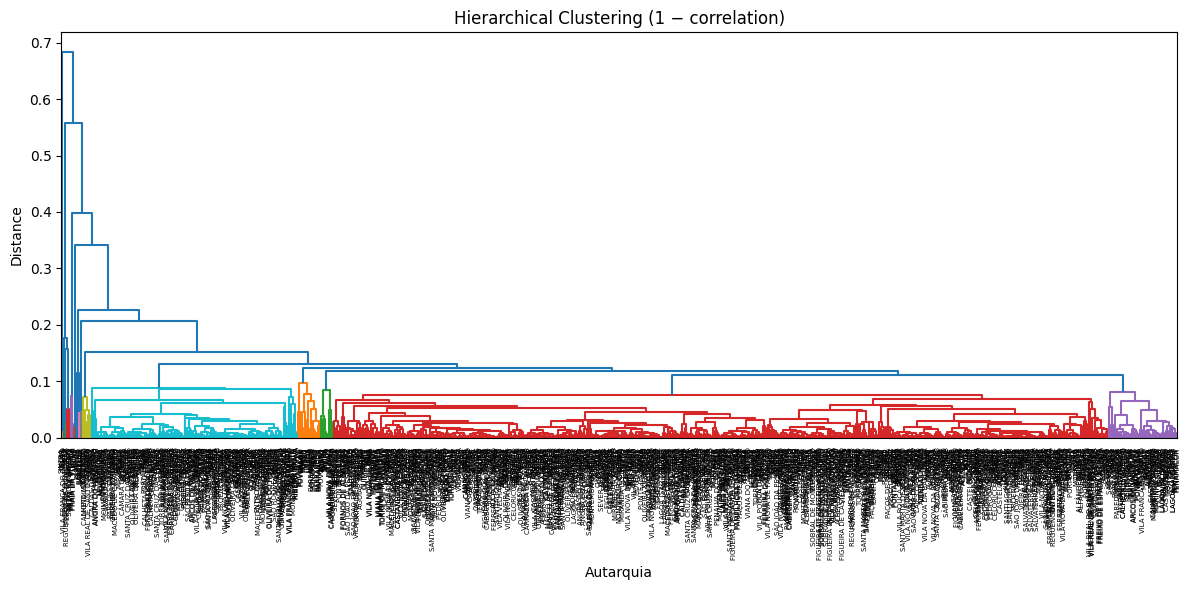

  autarquia  cluster
0  ABRANTES       14
1  ABRANTES       14
2  ABRANTES       14
3  ABRANTES       14
4    ÁGUEDA       14


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# 1) Identify your percentage columns
percent_cols = [c for c in despesas_resume_df.columns if c.endswith('_percent')]

# 2) Drop any rows that have NaN in *any* percent column
cluster_df = despesas_resume_df.dropna(subset=percent_cols).copy()

# 3) Extract the feature matrix
X = cluster_df[percent_cols].values
#    → shape = (n_autarquias_cleaned, n_categories)

# 4) Perform hierarchical clustering directly on X,
#    using correlation distance under the hood
Z = linkage(X, method='average', metric='correlation')

# 5) (Optional) Plot a dendrogram to pick a threshold
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=cluster_df['autarquia'].values,
    leaf_rotation=90,
    color_threshold=0.1
)
plt.title('Hierarchical Clustering (1 − correlation)')
plt.xlabel('Autarquia')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# 6) Cut the tree at distance = 0.1 (correlation ≥ 0.9)
cluster_df['cluster'] = fcluster(Z, t=0.1, criterion='distance')

# 7) Merge the cluster labels back into your original DataFrame
despesas_resume_df = despesas_resume_df.merge(
    cluster_df[['autarquia', 'cluster']],
    on='autarquia',
    how='left'
)

print(despesas_resume_df[['autarquia', 'cluster']].head())


            autarquia  cluster
11    AGUIAR DA BEIRA       11
12          ALANDROAL       11
13          ALANDROAL       11
29           ALCANENA       11
31           ALCANENA       11
...               ...      ...
4882       VILA VERDE       11
4894          VINHAIS       11
4903           VIZELA       11
4906          VOUZELA       11
4907          VOUZELA       11

[908 rows x 2 columns]
Autarquias in cluster 11: ['AGUIAR DA BEIRA', 'ALANDROAL', 'ALANDROAL', 'ALCANENA', 'ALCANENA', 'ALFÂNDEGA DA FÉ', 'ALIJÓ', 'ALIJÓ', 'ALIJÓ', 'ALIJÓ', 'ALMEIRIM', 'ALMEIRIM', 'ALMEIRIM', 'ALVAIÁZERE', 'ALVAIÁZERE', 'ALVITO', 'ALVITO', 'AMARANTE', 'AMARANTE', 'ANADIA', 'ANGRA DO HEROÍSMO', 'ANGRA DO HEROÍSMO', 'ANSIÃO', 'ANSIÃO', 'ANSIÃO', 'ARCOS DE VALDEVEZ', 'ARCOS DE VALDEVEZ', 'ARGANIL', 'ARGANIL', 'ARMAMAR', 'AROUCA', 'ARRONCHES', 'ARRONCHES', 'AVEIRO', 'AVEIRO', 'AVEIRO', 'AVIS', 'BAIÃO', 'BAIÃO', 'CADAVAL', 'CALDAS DA RAINHA', 'CALHETA (MADEIRA)', 'CALHETA (SÃO JORGE)', 'CALHETA (SÃO JORGE)'

In [39]:
# Count how many *unique* autarquias are in each cluster
cluster_counts = (
    despesas_resume_df
    .groupby('cluster')['autarquia']
    .nunique()             # count distinct autarquia names per cluster
    .sort_index()          # order by cluster label
)

print(cluster_counts)

# If you want it as a DataFrame:
cluster_counts_df = cluster_counts.reset_index(name='n_autarquias')
print(cluster_counts_df)

cluster
1       2
2       3
3       4
4       1
5       1
6       1
7       2
8       1
9       2
10      9
11    130
12      9
13      5
14    273
15     35
Name: autarquia, dtype: int64
    cluster  n_autarquias
0         1             2
1         2             3
2         3             4
3         4             1
4         5             1
5         6             1
6         7             2
7         8             1
8         9             2
9        10             9
10       11           130
11       12             9
12       13             5
13       14           273
14       15            35


In [40]:
import pandas as pd

# 1) Re‑use the list of percentage columns
percent_cols = [c for c in despesas_resume_df.columns if c.endswith('_percent')]

# 2) Compute the cluster centroids: mean % per category inside each cluster
cluster_profiles = (
    despesas_resume_df
    .groupby('cluster')[percent_cols]
    .mean()
    .sort_index()
)

# 3) View the raw profiles (each row is one cluster)
print("Cluster centroids (mean % per category):")
print(cluster_profiles)

# 4) For each cluster, pick the top 3 categories by average %
top_n = 3
for cluster, row in cluster_profiles.iterrows():
    top_cats = (
        row
        .sort_values(ascending=False)
        .head(top_n)
        .index
        .tolist()
    )
    print(f"Cluster {cluster}: top {top_n} spending categories → {top_cats}")

# 5) (Optional) Compare to overall averages to find which categories each cluster
#    over‑ or under‑indexes on:
overall_mean = despesas_resume_df[percent_cols].mean()
delta = cluster_profiles.subtract(overall_mean, axis=1)

print("\nDifference from overall mean (cluster minus global):")
print(delta)


Cluster centroids (mean % per category):
         despesas_com_pessoal_percent  aquisicao_bens_servicos_percent  \
cluster                                                                  
1                           23.588471                        18.005347   
2                           26.719208                        24.340817   
3                           30.257829                        28.736300   
4                           22.913392                        18.546632   
5                           22.837171                        13.715162   
6                           18.529915                        12.741732   
7                           31.294549                        23.625432   
8                           24.720461                        22.547213   
9                           38.984308                        24.205016   
10                          27.632853                        23.715395   
11                          29.508062                        23.579691 

In [42]:
# ------------------------------------------------------------
# 9) Specify the output folder and filename
# ------------------------------------------------------------
output_folder = './datasets/financial'
output_filename = 'despesas_combinadas_resume.xlsx'
output_path = os.path.join(output_folder, output_filename)

# 10) Ensure the output directory exists
os.makedirs(output_folder, exist_ok=True)

# 11) Write the DataFrame to Excel
despesas_resume_df.to_excel(
    output_path,
    index=False,
    engine='openpyxl'
)